In [1]:
# Basic packages
import numpy as np
import time
import sys
import os
from pathlib import Path
import logging
import importlib

import pandas as pd
pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings("ignore")

# Astropy packages
from astropy.table import Table
from astropy.io import fits

# Matplotlib packages
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy.optimize import curve_fit
from scipy import signal


import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore')


# Useful if working in SSH Vscode
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)
import AnalysisFunctions as af
from stellarmodel import StellarModel



sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap

# Accepts mass, log(age), metallicity. Outputs Teff, logg, and log(L) bolometric (flux)
isochrone_table = Table.read(working_directory +  '/assets/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
isochrone_interpolator = af.load_isochrones()

# Results from CCF
results_text = pd.read_csv("/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis" + "/CCF_results.txt", sep='\t', names=["sobject_id", "no_peaks", "RVs"])
results_text['index'] = results_text.index

GALAH_DR4_dir = '/avatar/buder/GALAH_DR4/'
if 'GALAH_DR4' not in locals():
    GALAH_DR4 = ap.FitsToDF(GALAH_DR4_dir + "catalogs/galah_dr4_allspec_240207.fits")
    # GALAH_DR4 = ap.FitsToDF("/avatar/yanilach/PhD-Home/binaries_galah-main/catalogs/galah_dr4_allspec_240207.fits")
    


/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis/


In [214]:
# Some obvious binary stars for testing.

if os.path.exists(working_directory + "obvious_binaries.csv"):
    obvious_binaries = pd.read_csv(working_directory + "obvious_binaries.csv")
else:
    obvious_binaries = []
    binary_stars = results_text[results_text['no_peaks'] == 2]
    for sobject_id in binary_stars['sobject_id']:
        dir = GALAH_DR4_dir + 'observations/' + str(sobject_id)[:6] + '/spectra/com/' + str(sobject_id) + '1.fits'
        if os.path.exists(dir):
            obvious_binaries.append(sobject_id)

    df = pd.DataFrame(obvious_binaries)
    df.to_csv(working_directory + "obvious_binaries.csv", index=False)

print(len(obvious_binaries))

3023


Succsefully found file for object /avatar/buder/GALAH_DR4/observations/140116/spectra/com/1401160043013991.fits
{'mass': 1.0135011672973633, 'age': 6.371642112731934, 'metallicity': -0.5258811116218567, 'rv': 55.12256622314453, 'fe_h': -0.6139580607414246, 'vmic': 1.5, 'vsini': 4.0, 'teff': 4.304216861534354, 'logg': 1.4687870670059602, 'logl': 2.4625790445960765}


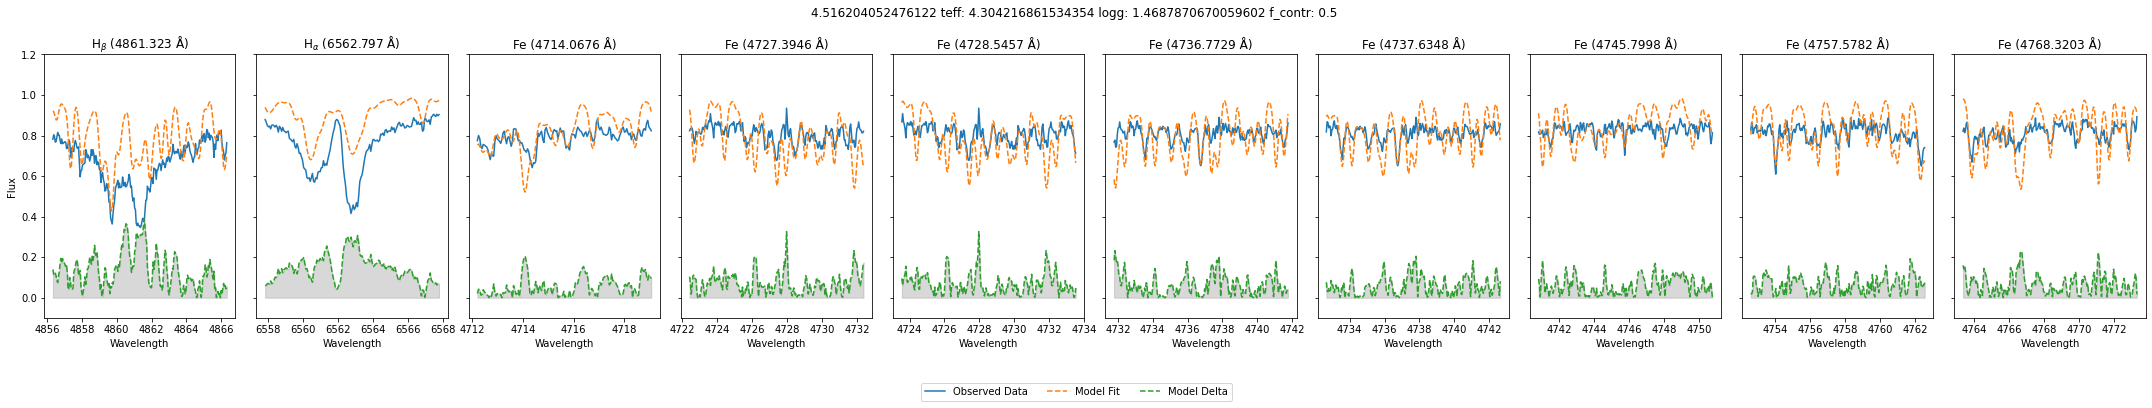

{'f_contr': 0.5, 'mass_1': 1.0135011672973633, 'age_1': 6.371642112731934, 'metallicity_1': -0.5258811116218567, 'rv_1': 55.12256622314453, 'fe_h_1': -0.6139580607414246, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.0135011672973633, 'age_2': 6.371642112731934, 'metallicity_2': -0.5258811116218567, 'rv_2': -52.0, 'fe_h_2': -0.6139580607414246, 'vmic_2': 1.5, 'vsini_2': 4.0, 'teff_1': 4.304216861534354, 'teff_2': 4.304216861534354, 'logg_1': 1.4687870670059602, 'logg_2': 1.4687870670059602, 'logl_1': 2.4625790445960765, 'logl_2': 2.4625790445960765}


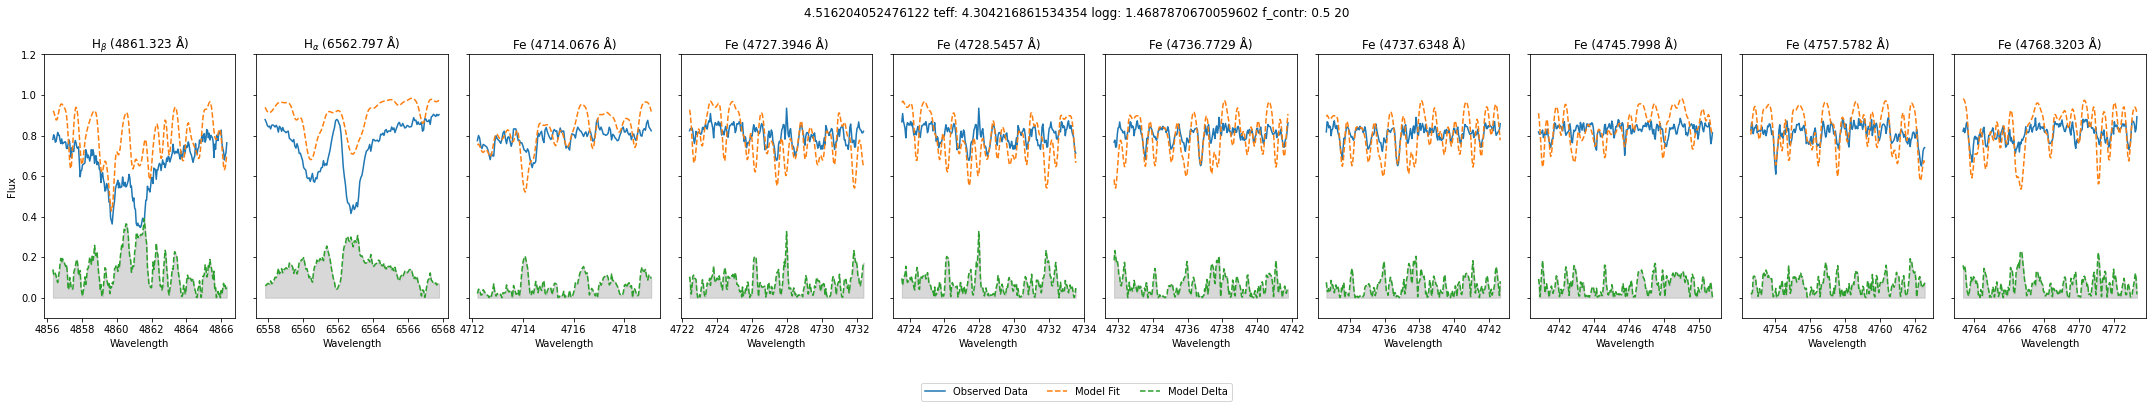

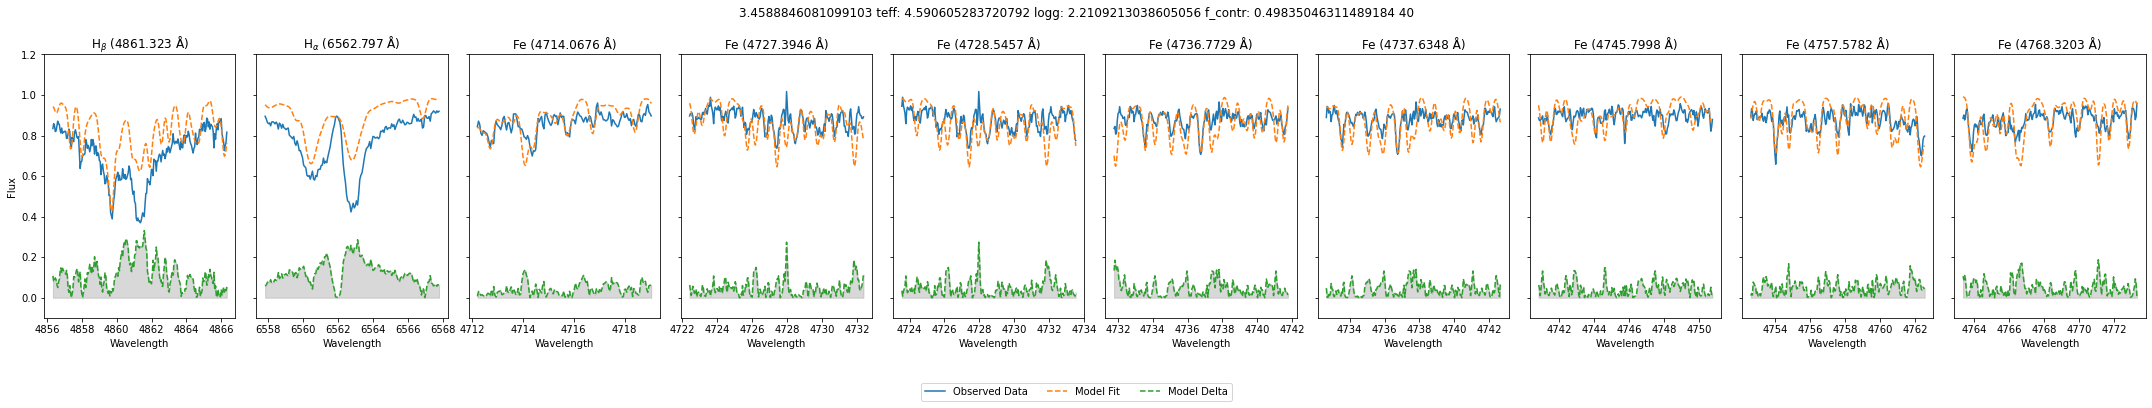

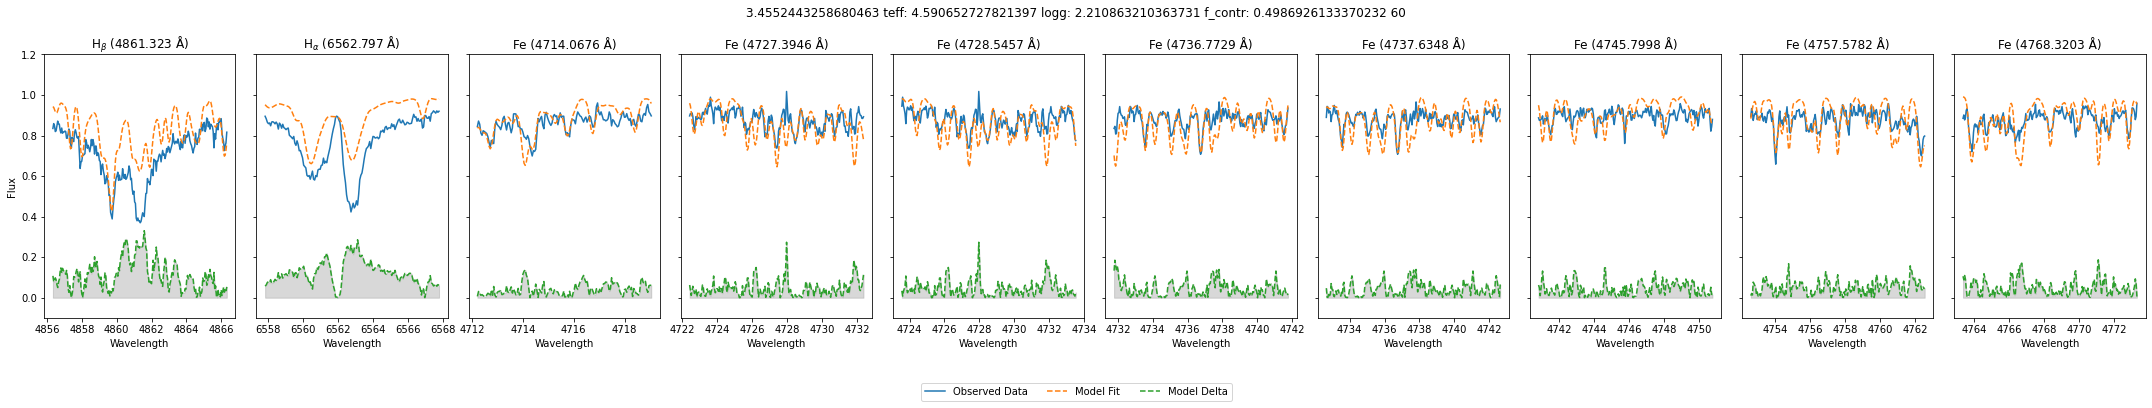

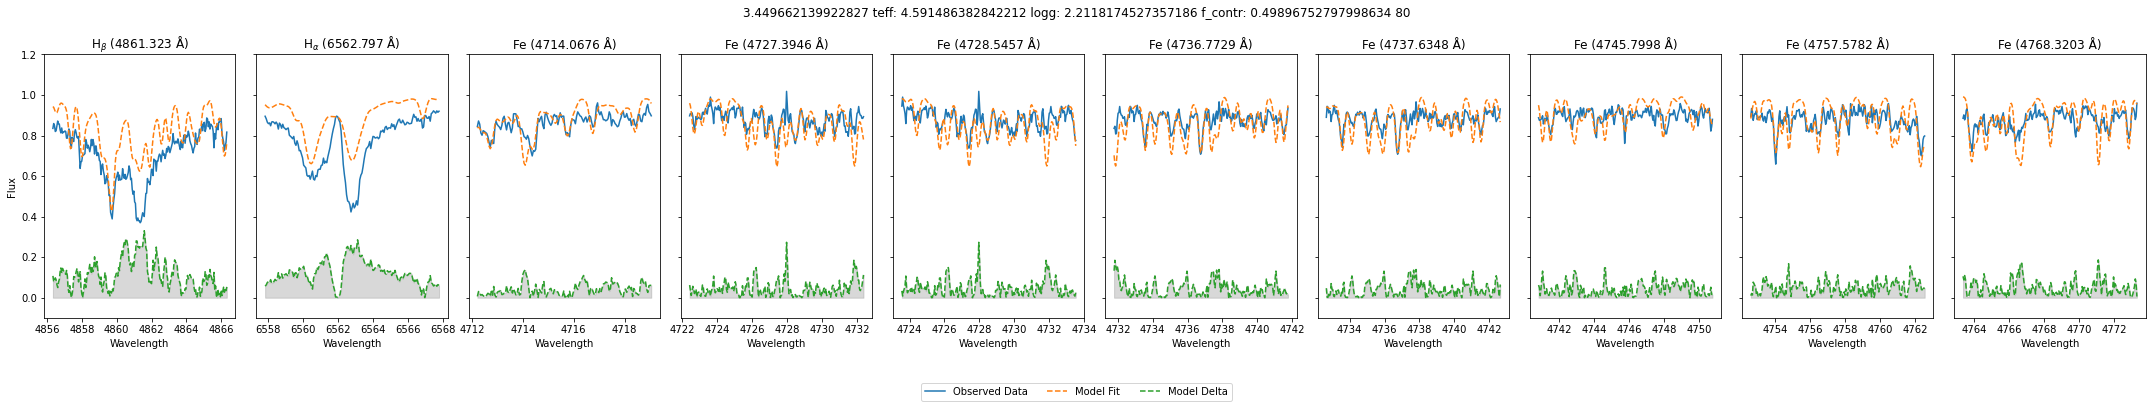

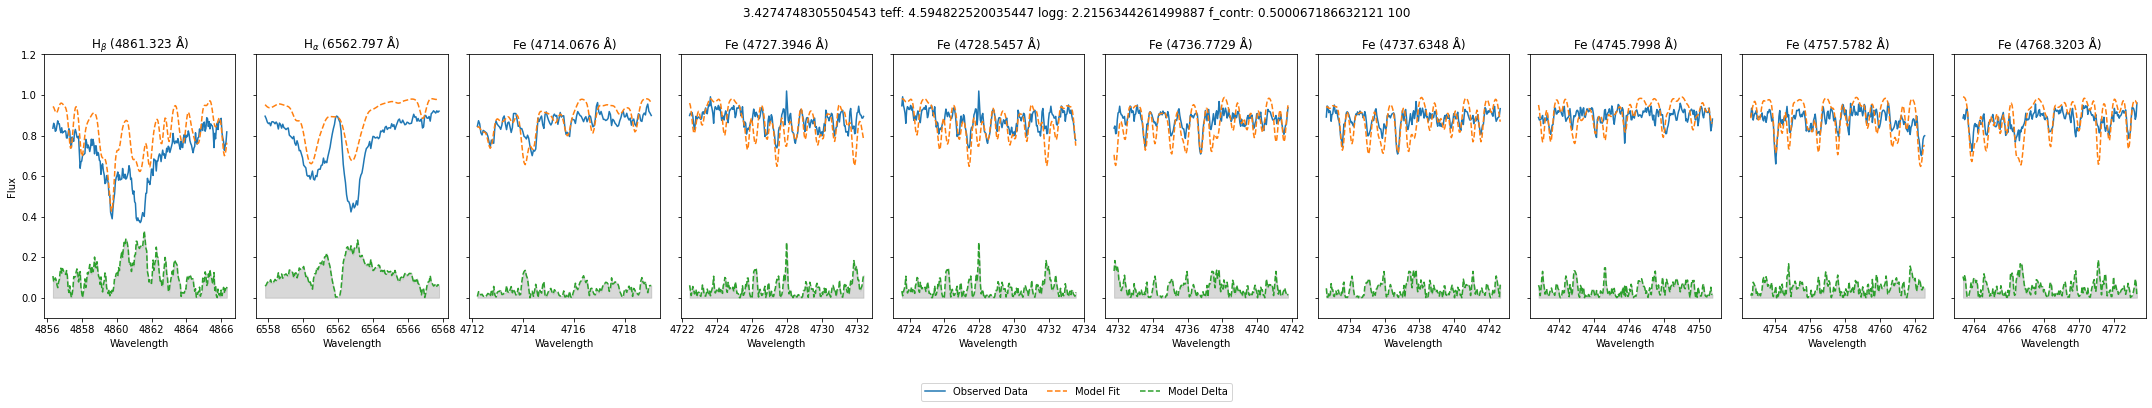

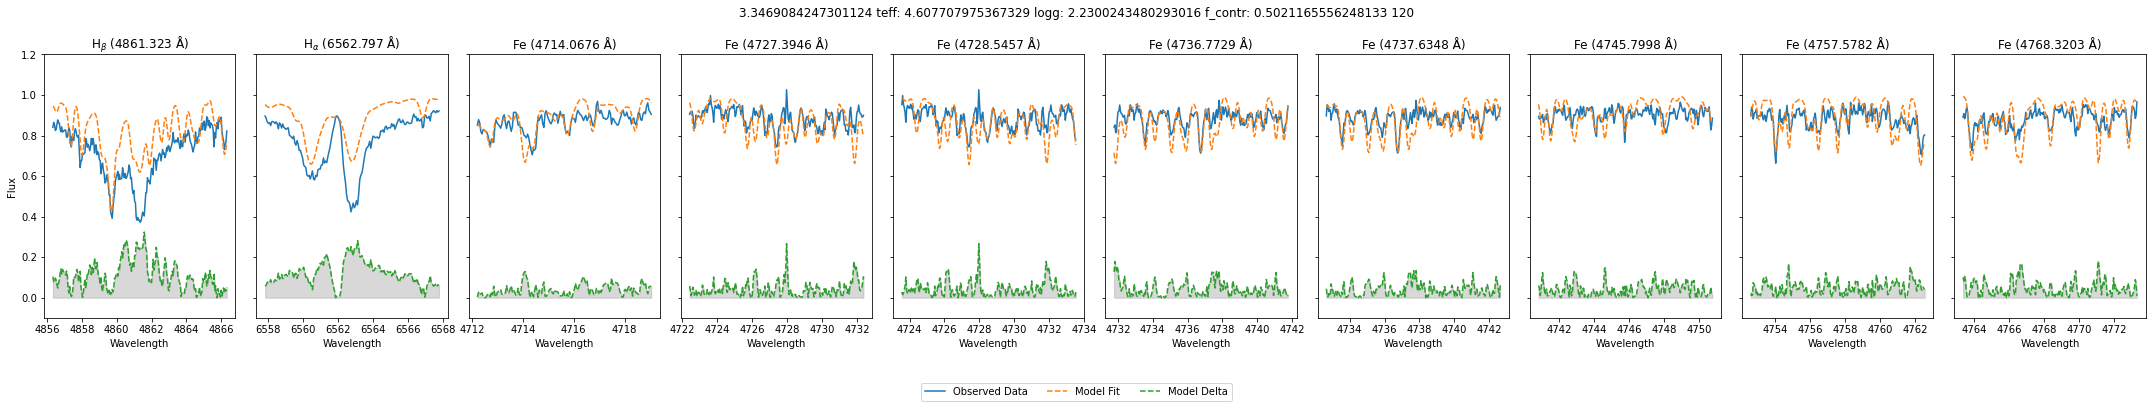

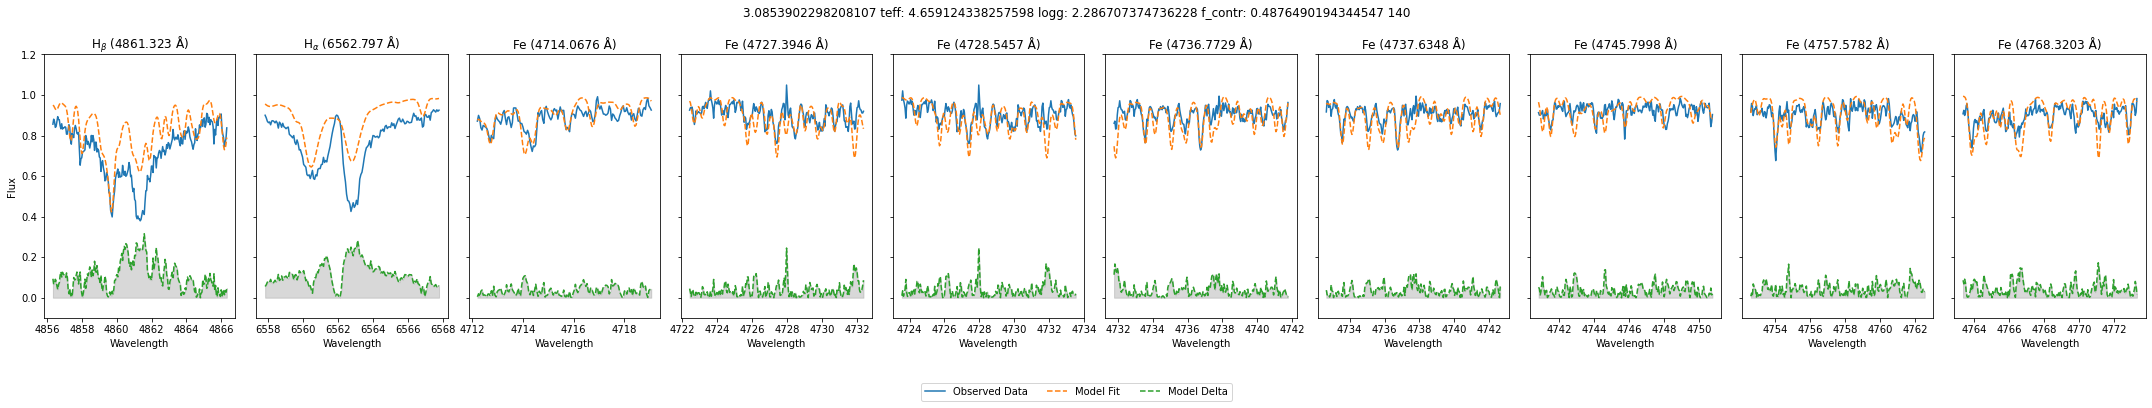

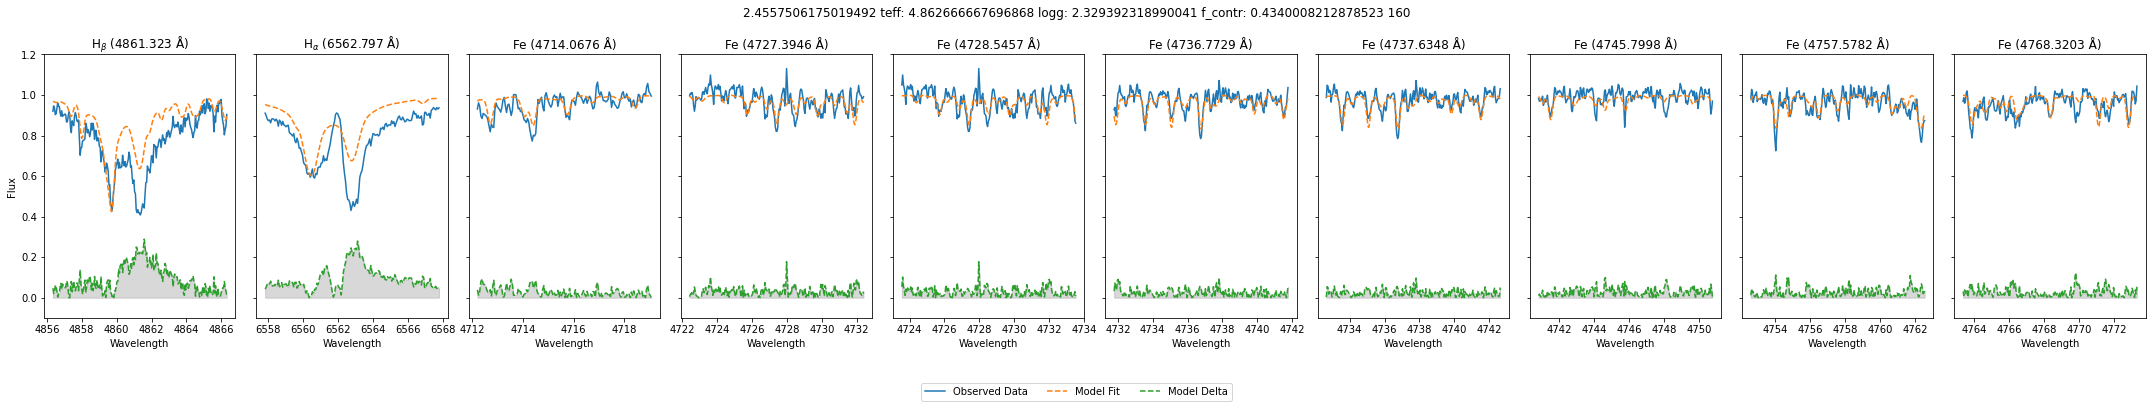

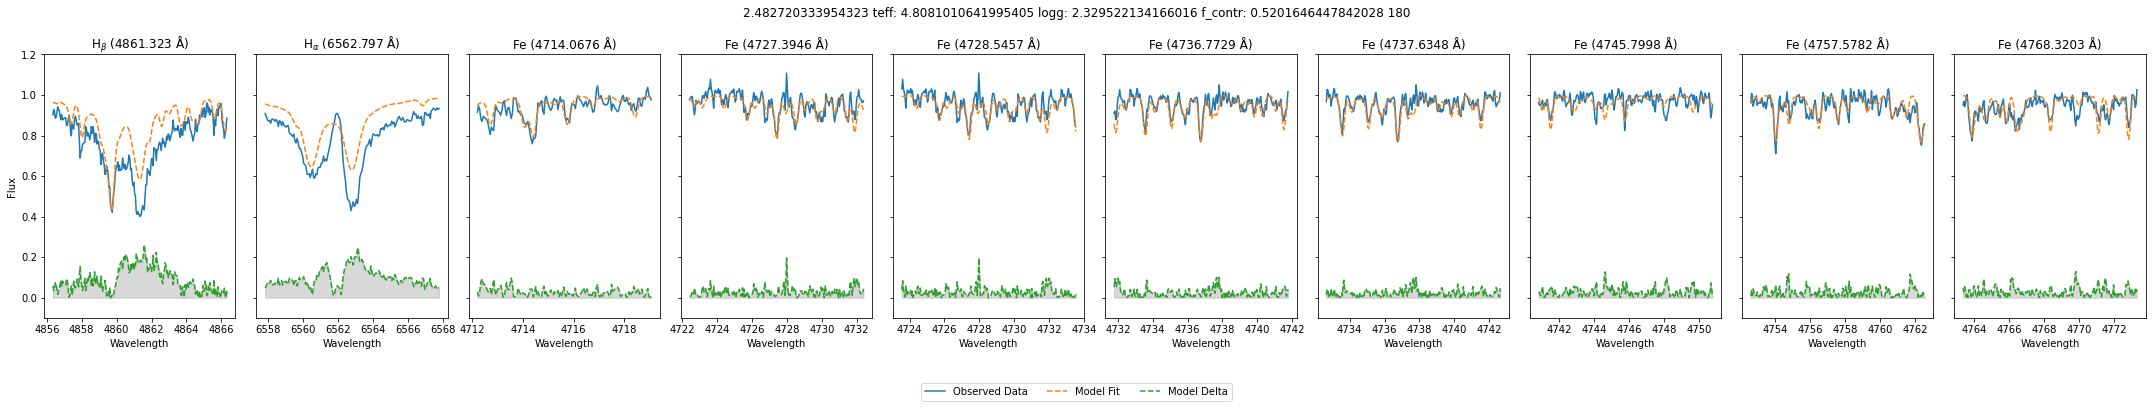

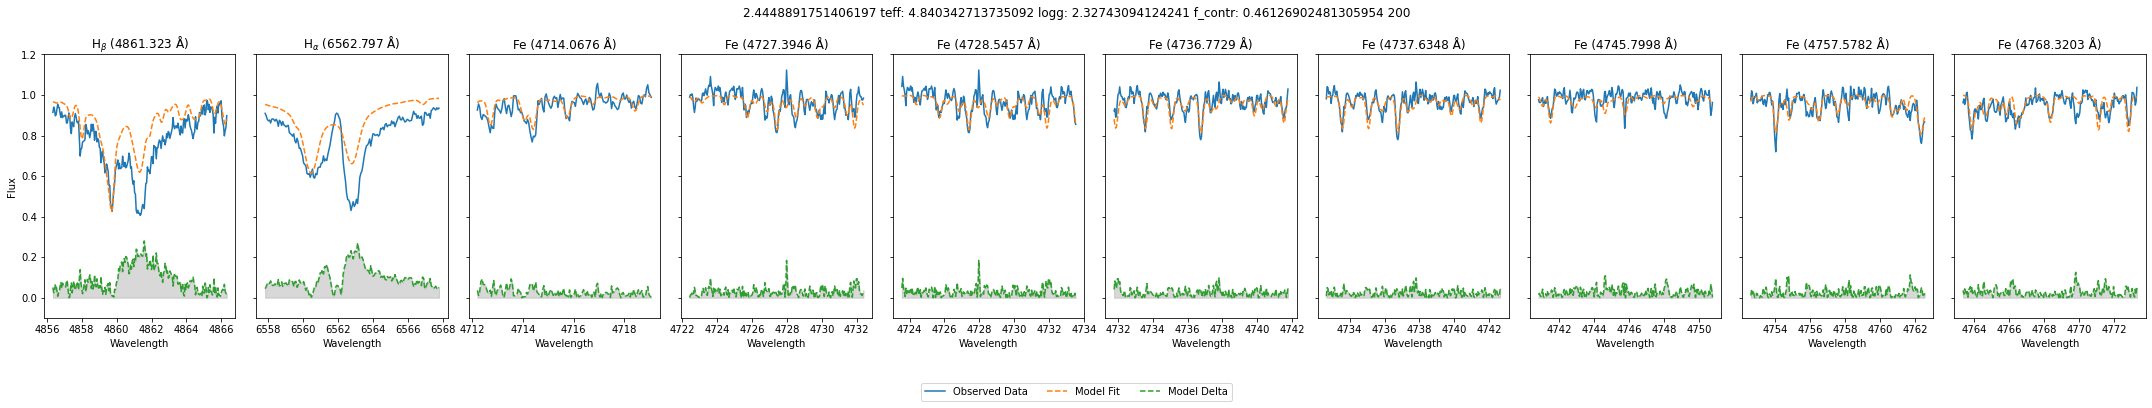

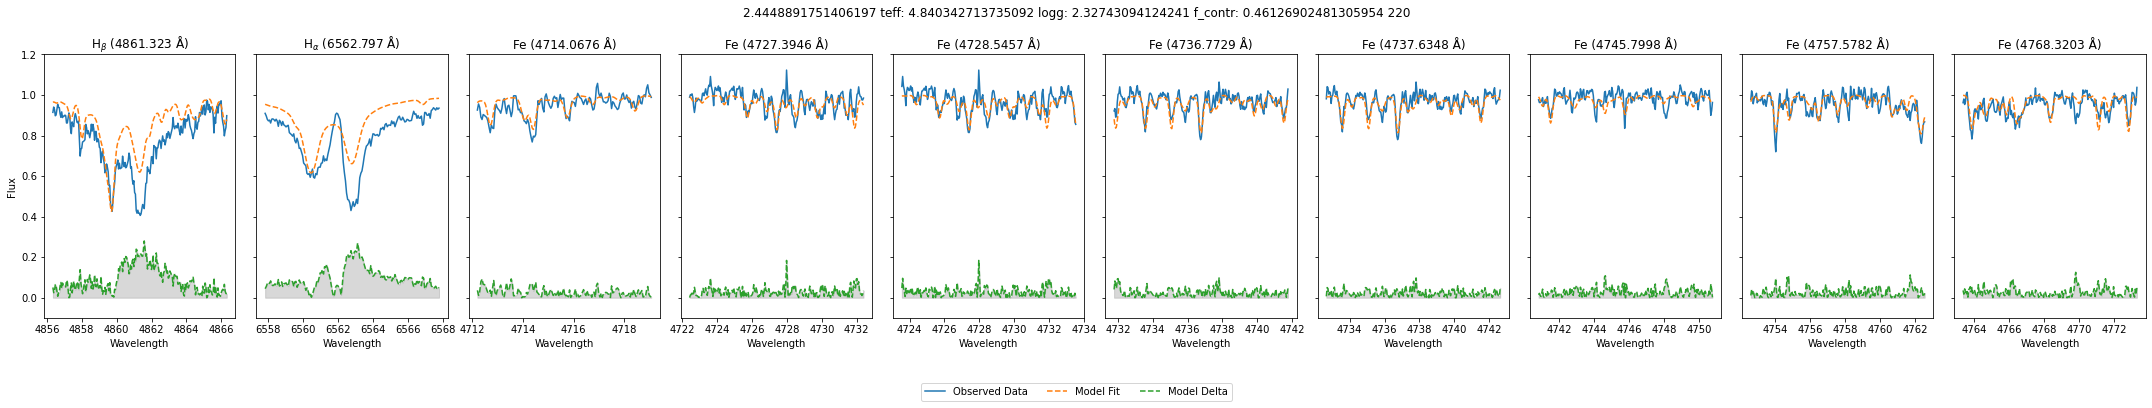

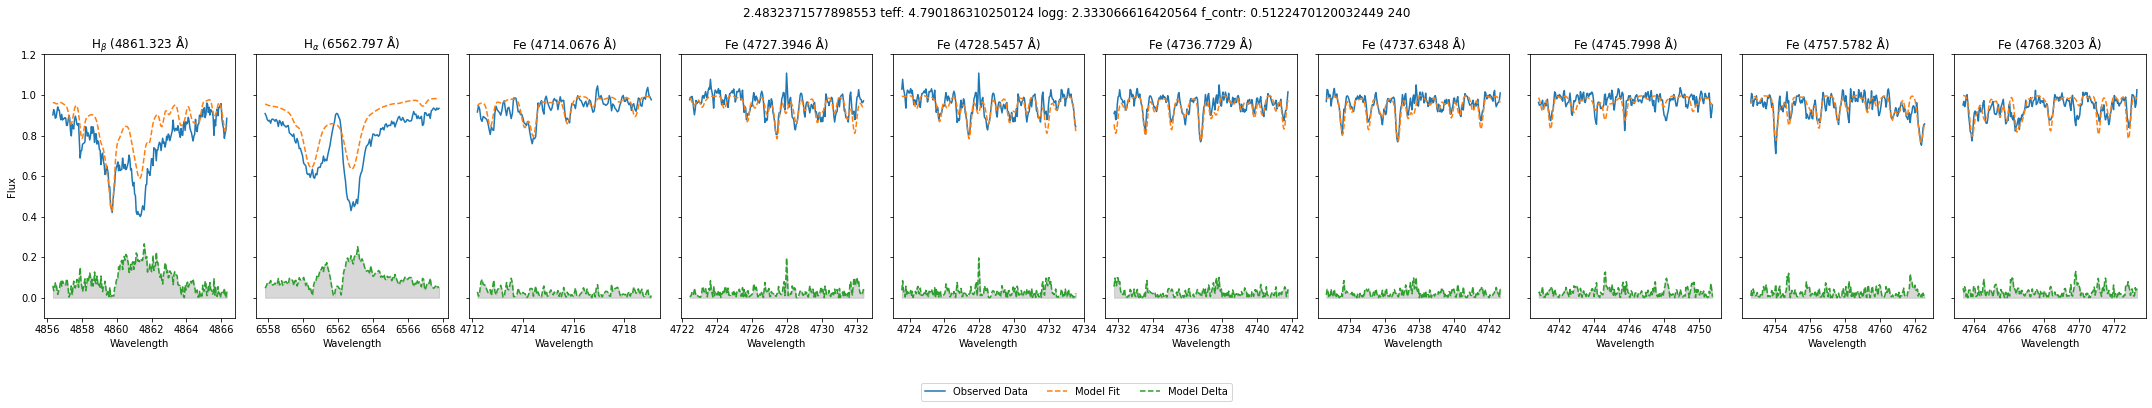

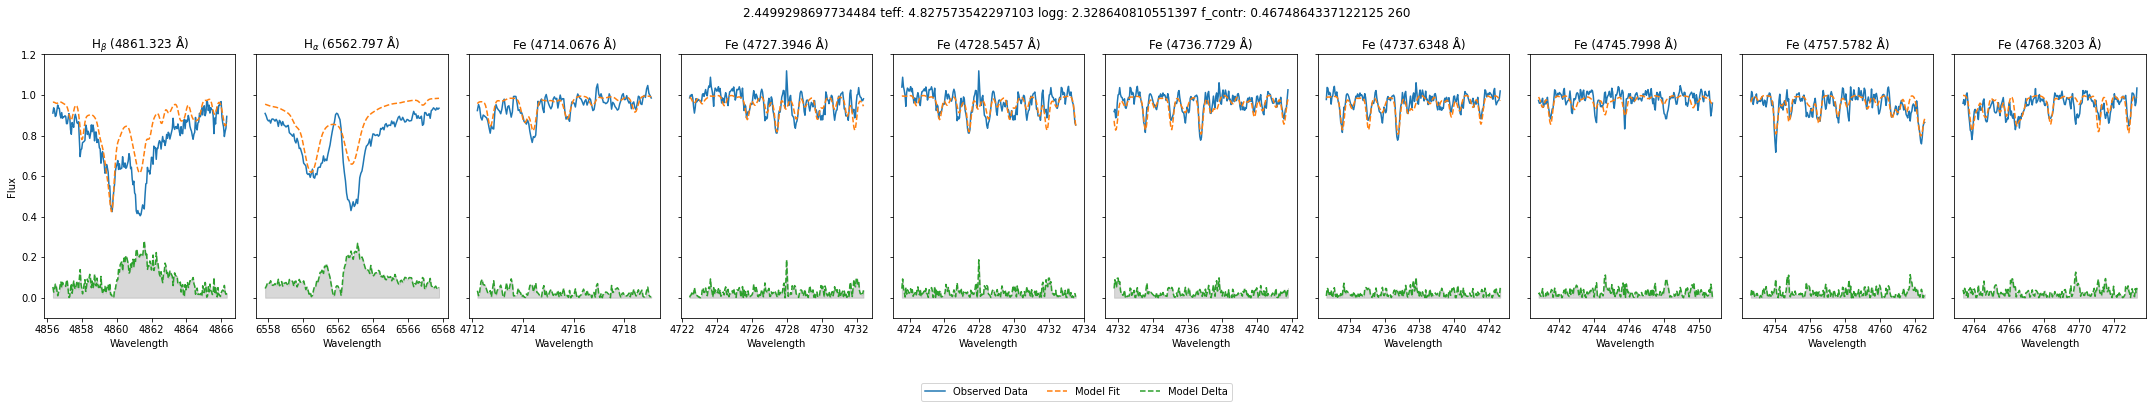

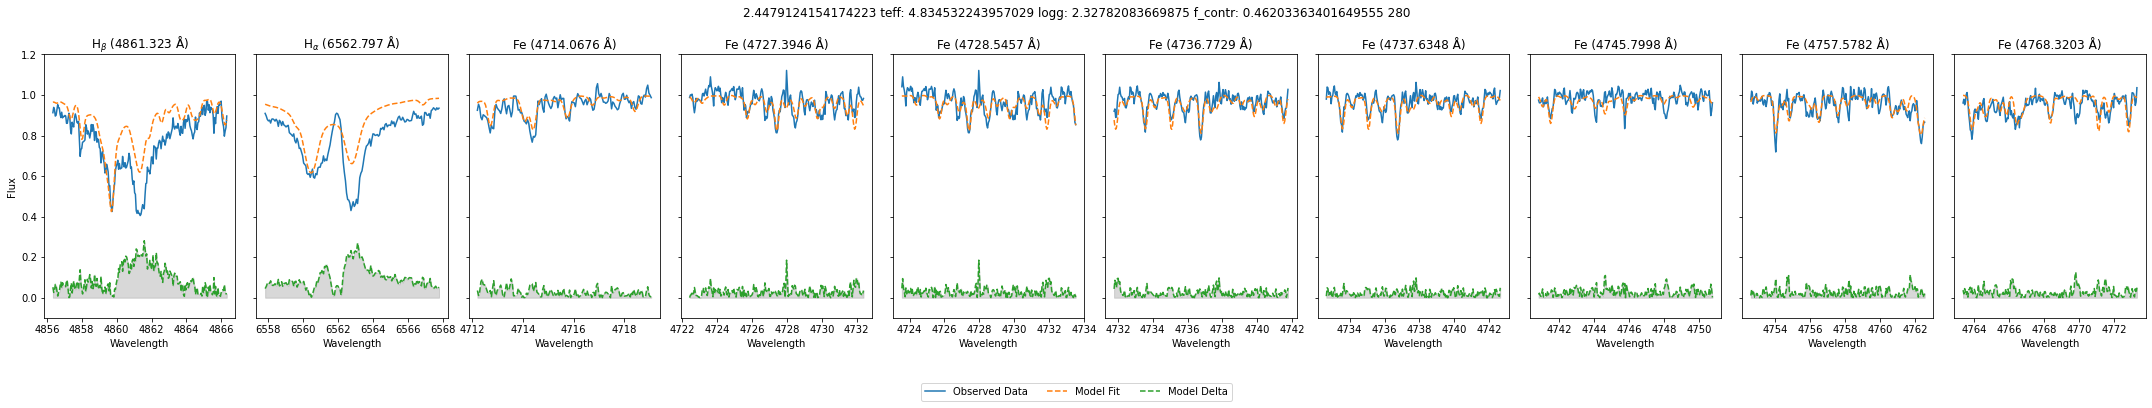

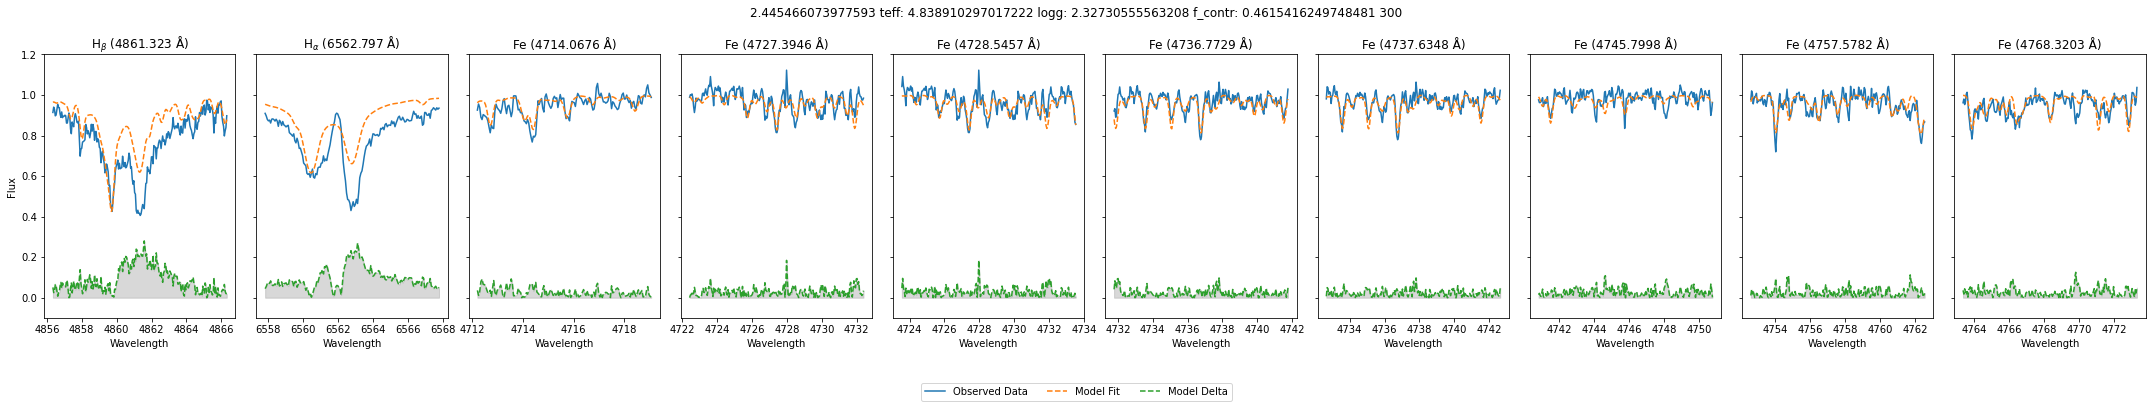

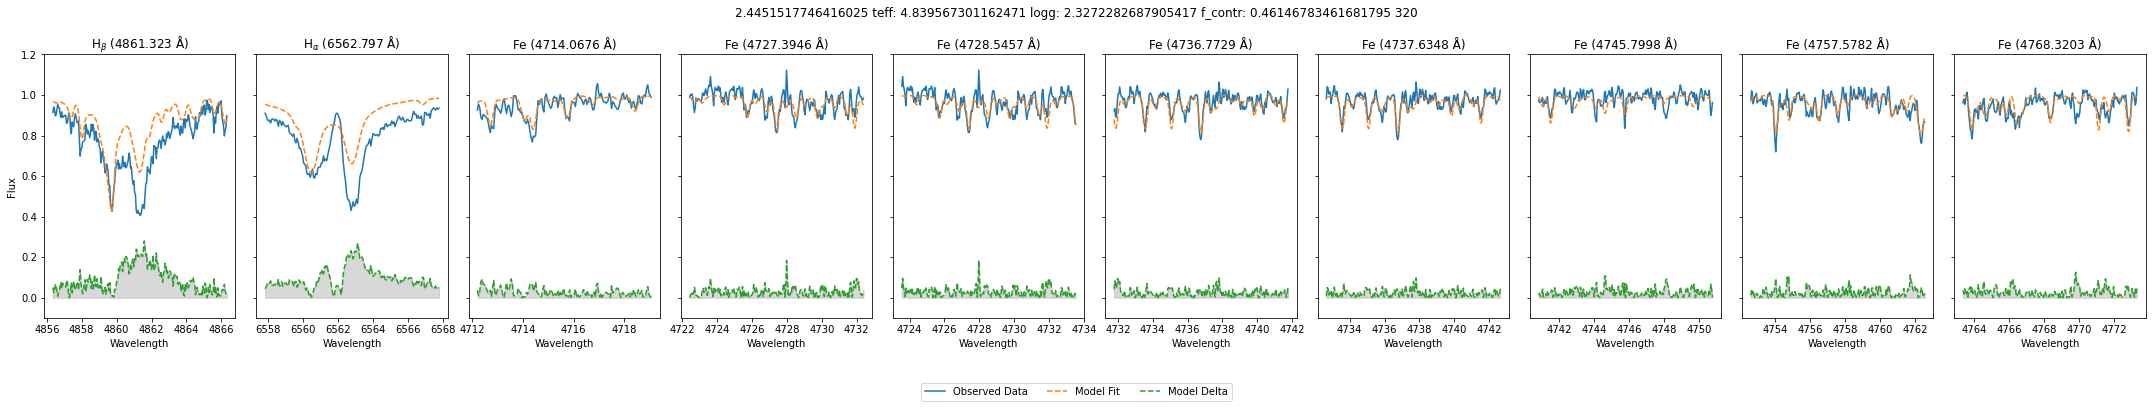

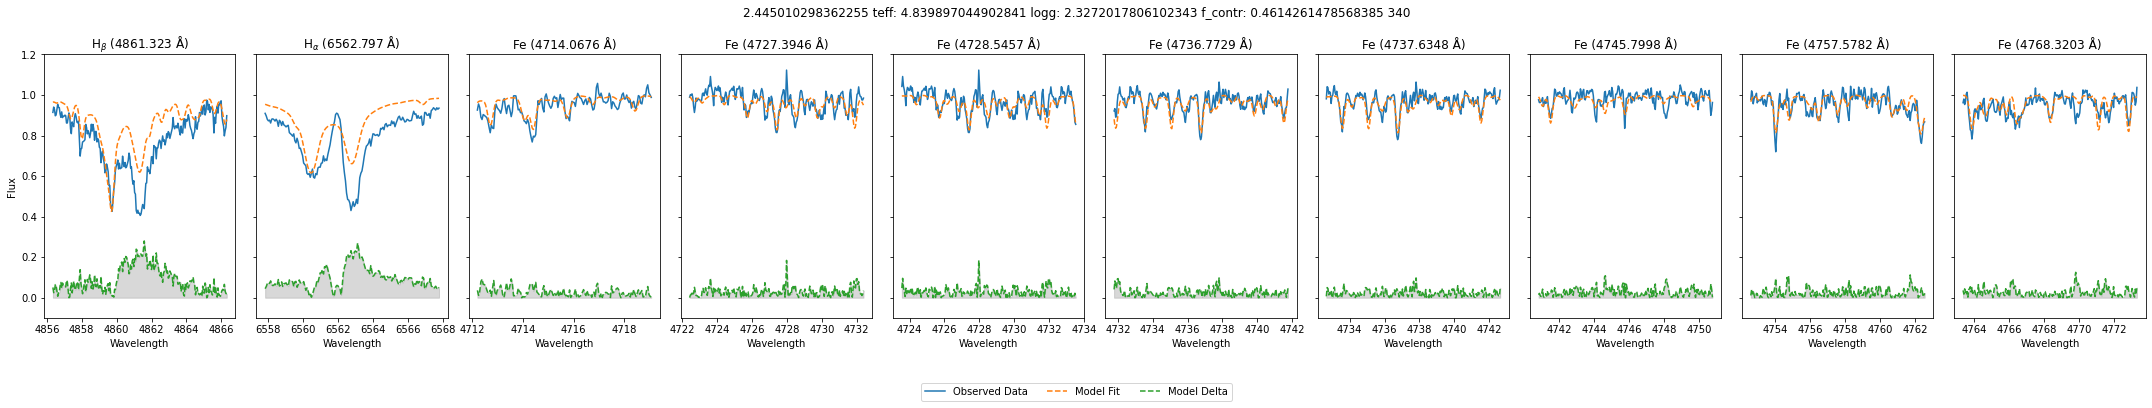

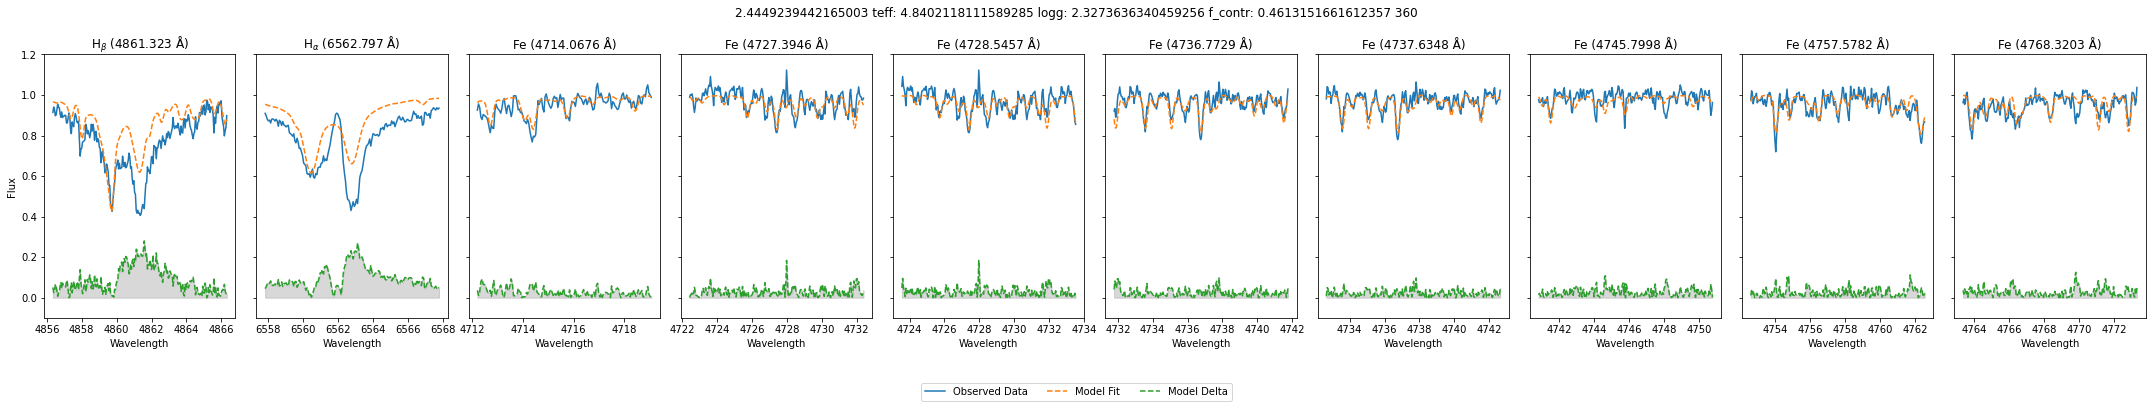

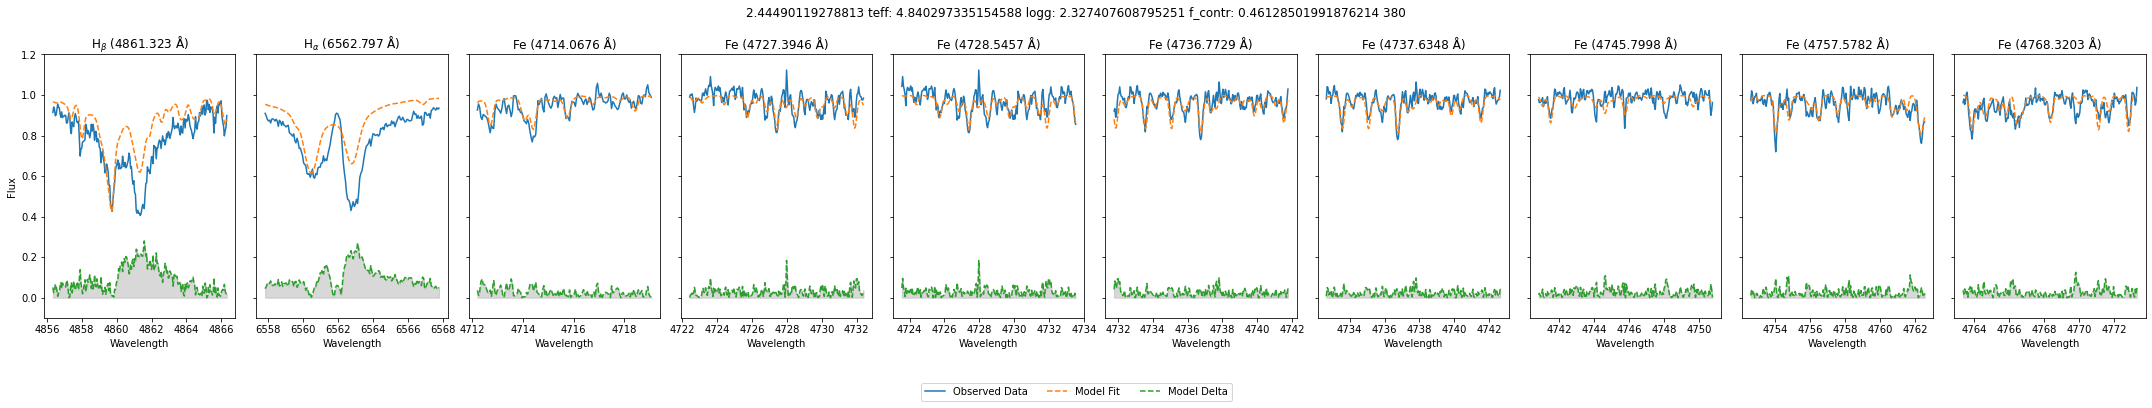

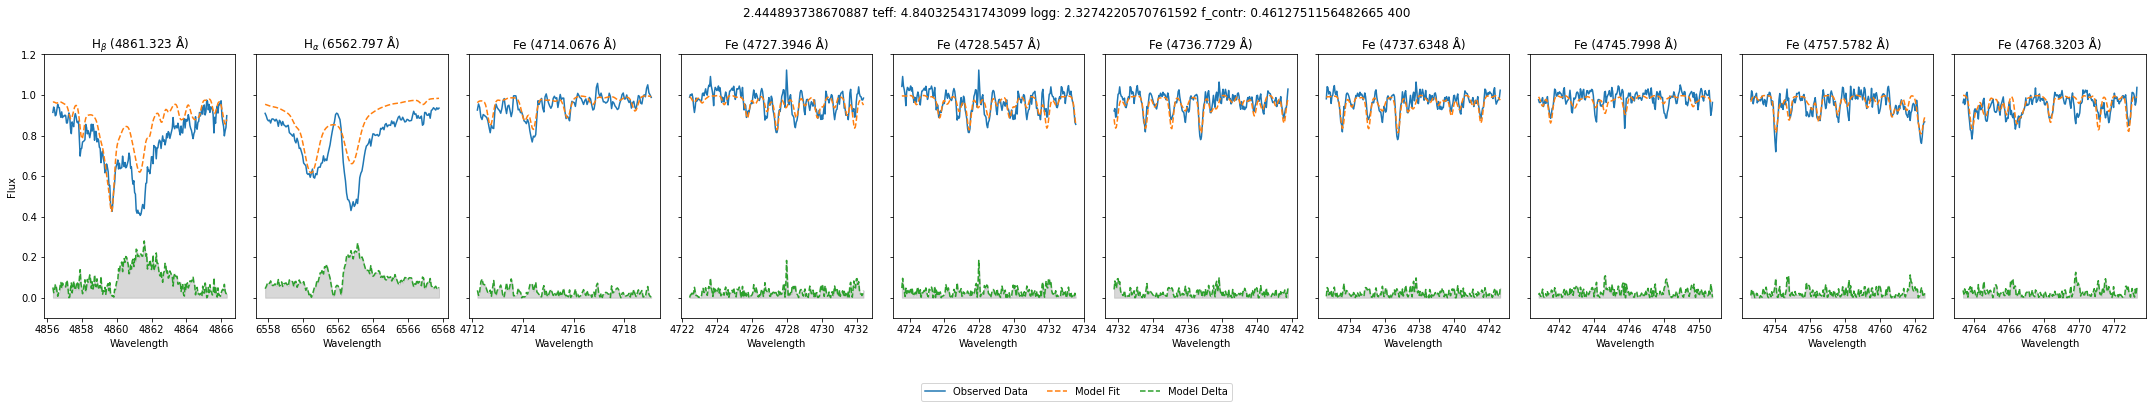

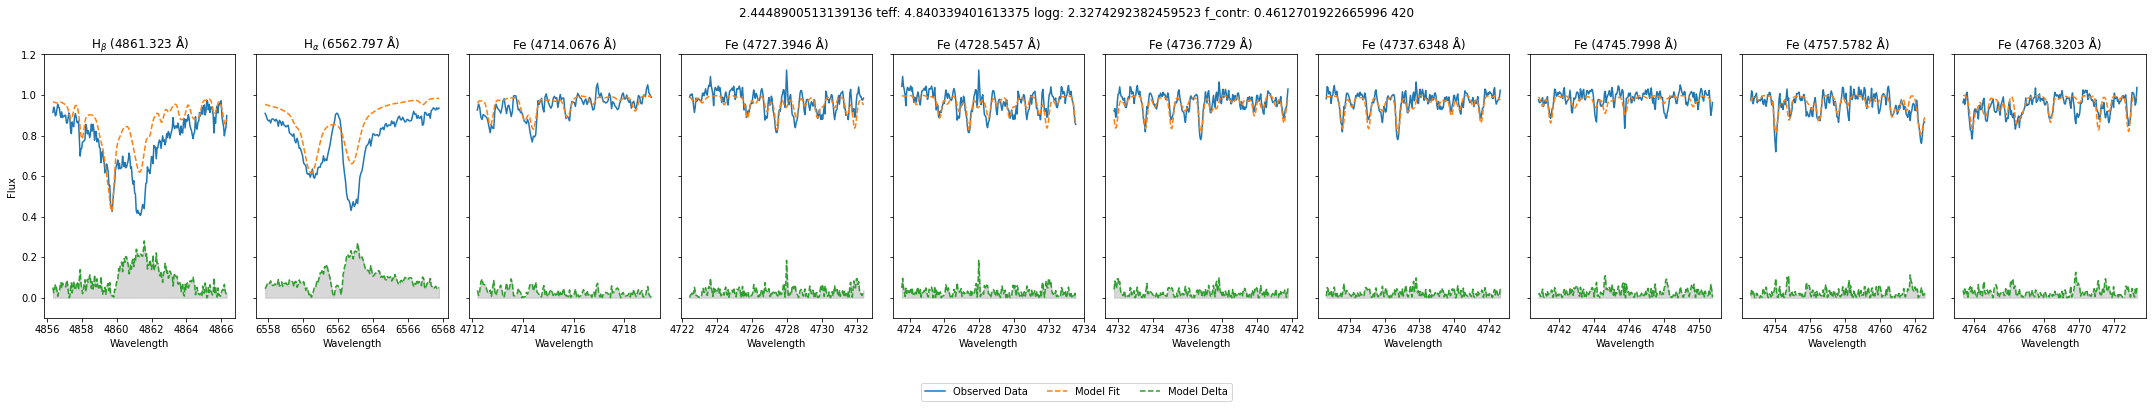

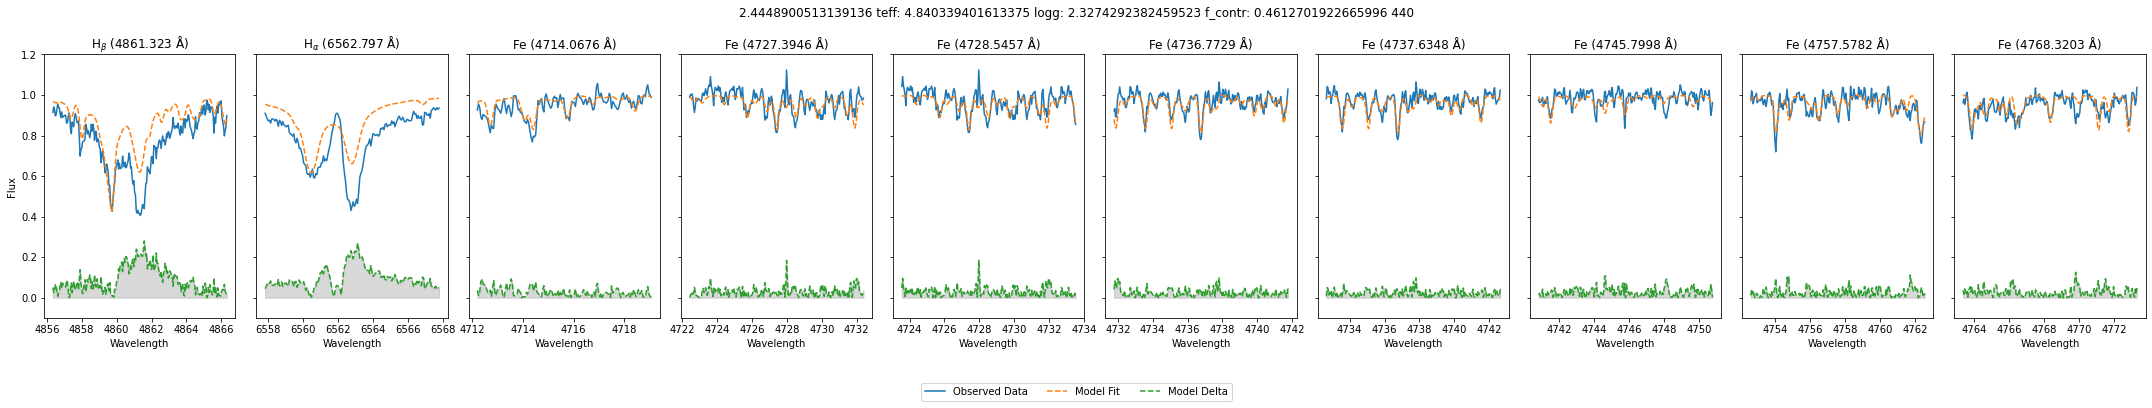

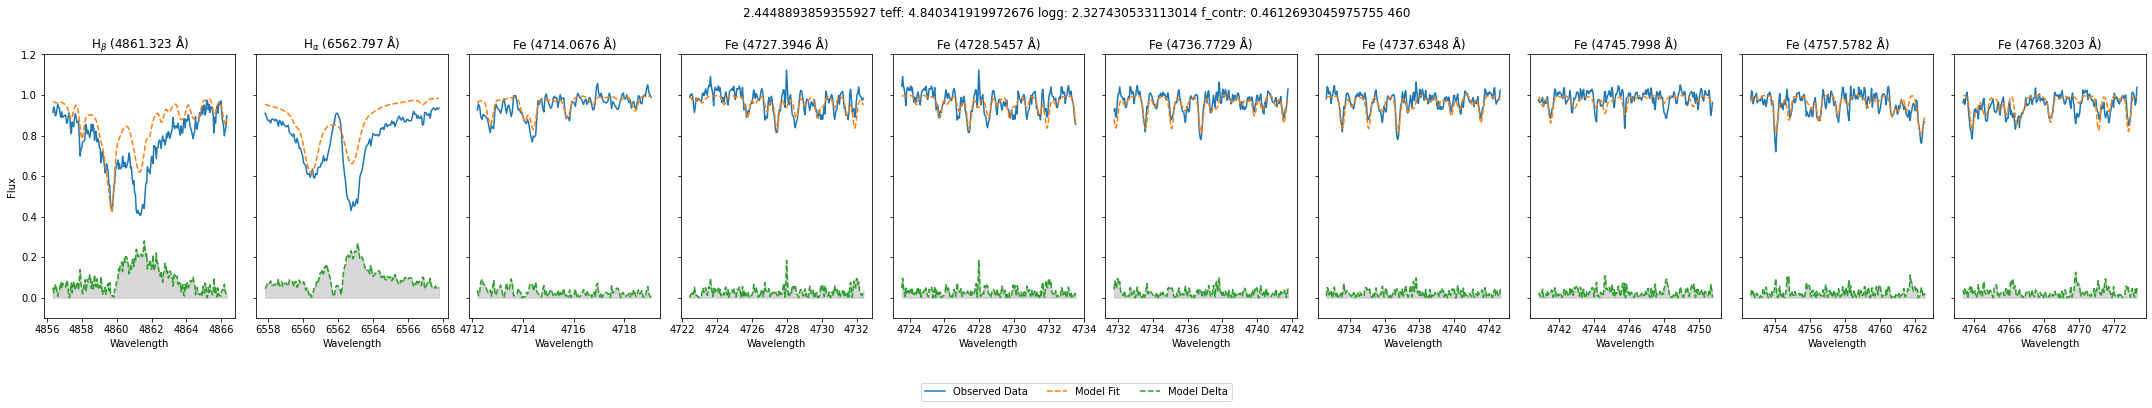

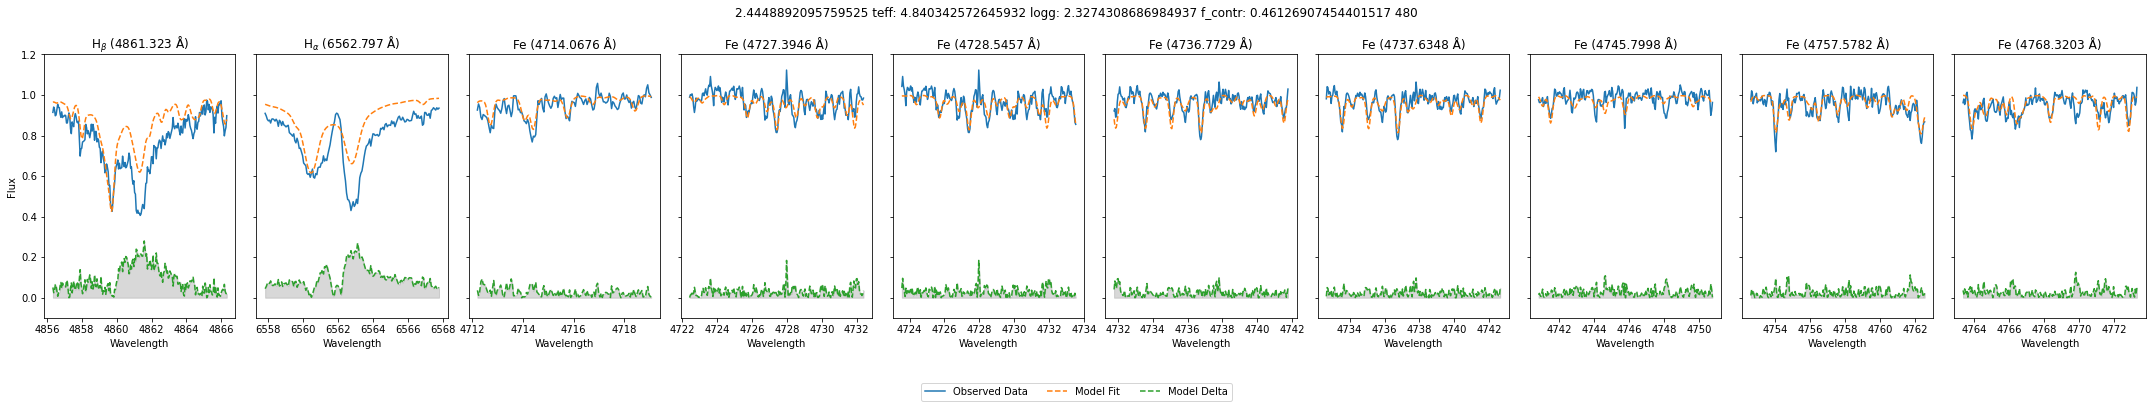

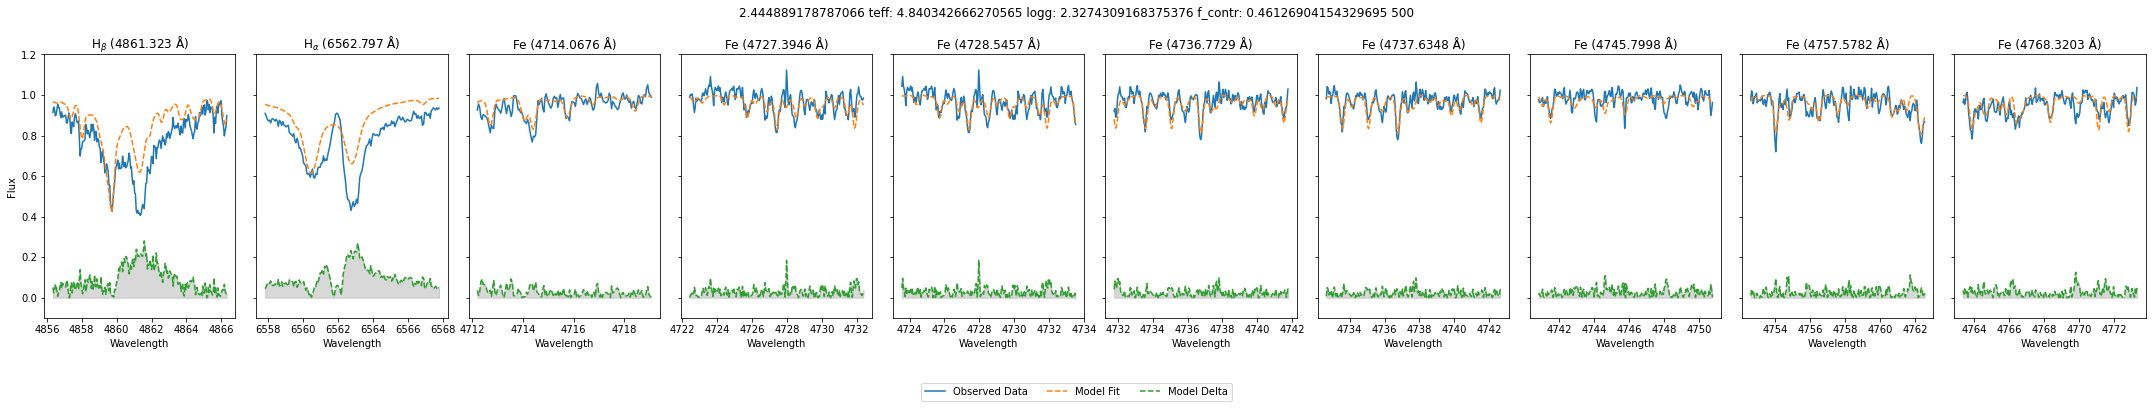

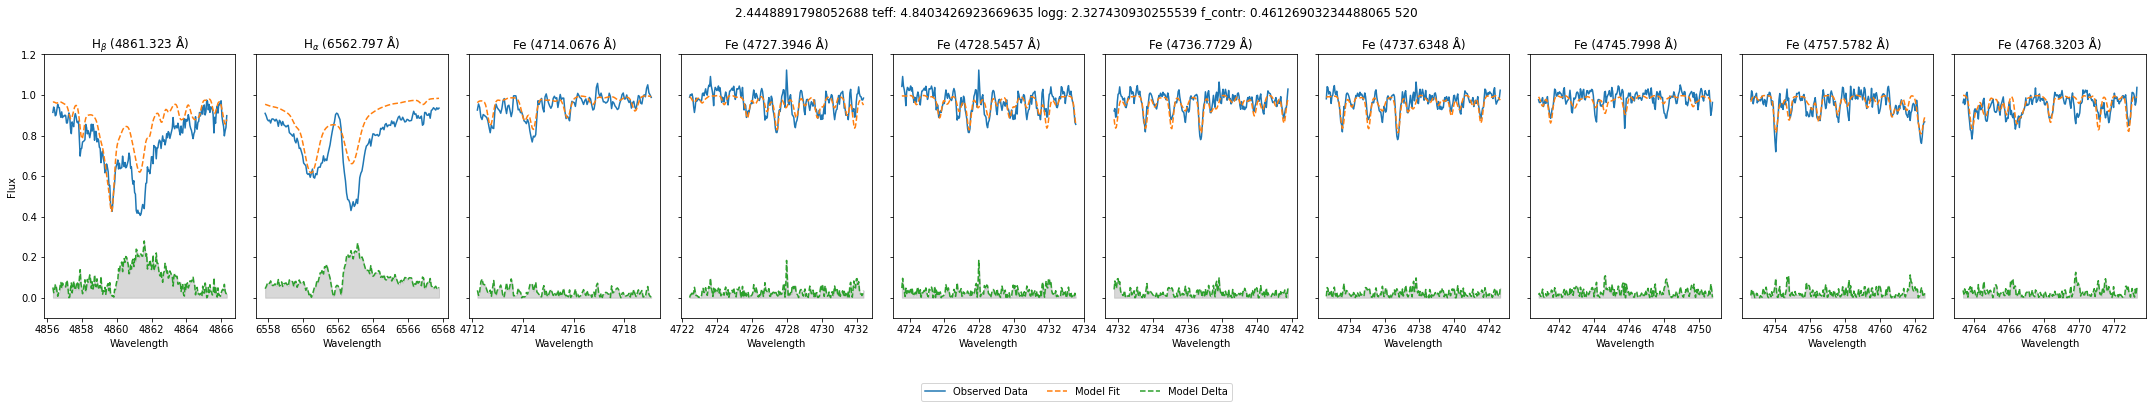

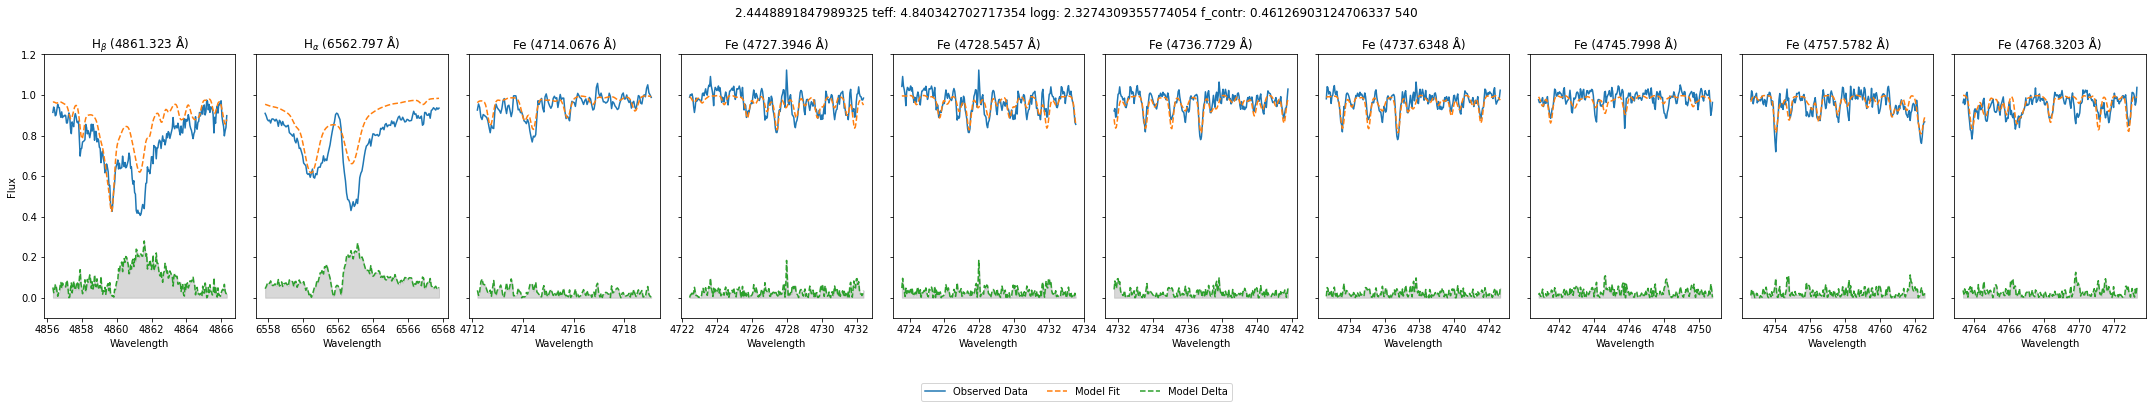

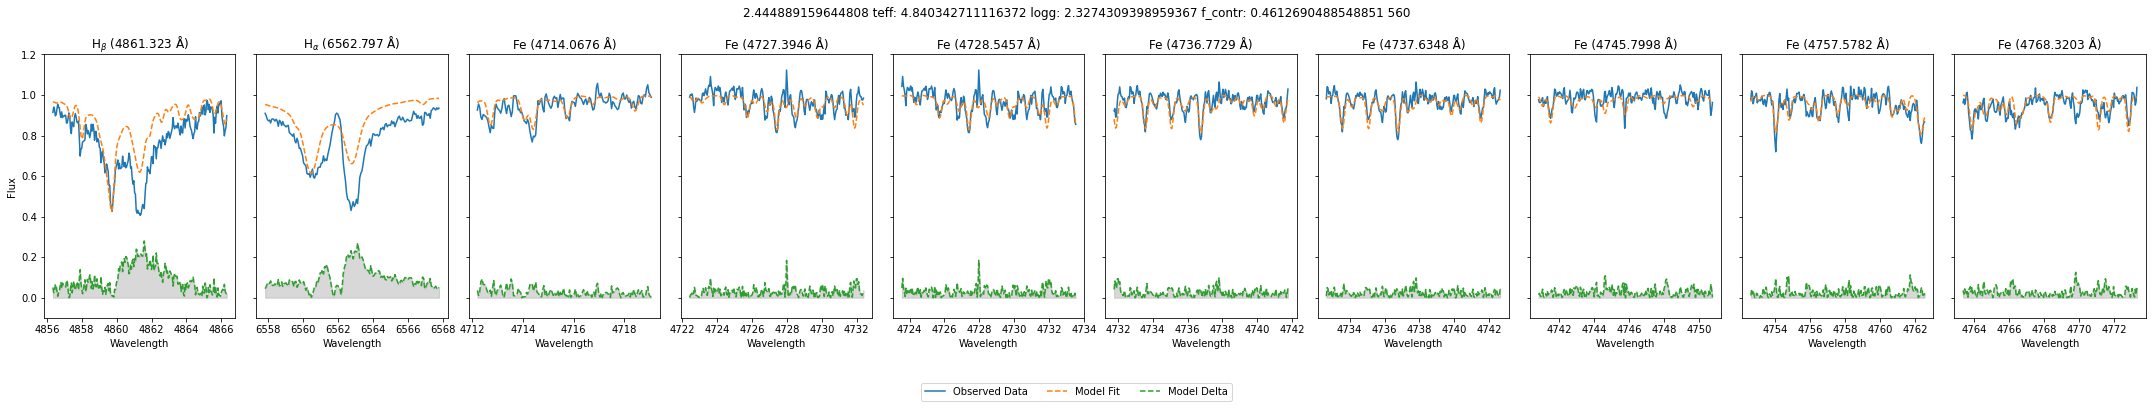

Final parameters:
{'f_contr': 0.46126902573610395, 'mass_1': 1.4120738905470653, 'age_1': 5.677786212851507, 'metallicity_1': -0.8827928308920359, 'rv_1': 55.06354921341807, 'fe_h_1': -1.1490277001916431, 'vmic_1': 1.4033690765626246, 'vsini_1': 4.044577334987093, 'mass_2': 1.4978779488285936, 'age_2': 5.792982758856851, 'metallicity_2': -1.1590614721407102, 'rv_2': -52.12039203265708, 'fe_h_2': -1.5375764371153717, 'vmic_2': 1.2331386442837253, 'vsini_2': 4.305794683497533, 'teff_1': 4.840342711116372, 'teff_2': 4.949694970561034, 'logg_1': 2.3274309398959367, 'logg_2': 2.2896193668471927, 'logl_1': 1.8472487745489043, 'logl_2': 1.9146664278477652}


In [210]:
# Reload these each time in case we update the files (for now)
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel

# sobject_id = 131216002101139 # Sven's example
sobject_id = obvious_binaries['0'][70]
sobject_id = 140116004301399
sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
tmass_id = sobject_data['tmass_id'].values[0]

spectrum = af.read_spectrum(sobject_id, tmass_id)
same_fe_h = False

try:
    single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
except:
    print('Single results not available')
    exit()


# model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
model = StellarModel(labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


model.bounds['f_contr'] = (0, 1)

# Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
model.set_bounds('rv', (-900, 900))
model.set_bounds('teff', (3, 8))
model.set_bounds('logg', (0.0, 5.0))
model.set_bounds('fe_h', (-4.0, 1.0))
model.set_bounds('vmic', (0, 4))
model.set_bounds('vsini', (0, 30))

age_min = (10**isochrone_table['logAge'].min()) / 1e9
age_max = (10**isochrone_table['logAge'].max()) / 1e9

model.set_bounds('age', (age_min, age_max))
model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))

model.params['f_contr'] = 0.5


model.params['rv_1'] = single_results['rv_gauss'][0]
model.params['rv_2'] = single_results['rv_peak_2'][0]

model.set_param('teff', single_results['teff'][0]/1000.)
model.set_param('logg', single_results['logg'][0])

model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))
model.set_param('mass', sobject_data['mass'].values[0])
model.set_param('metallicity', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h

model.set_param('fe_h', single_results['fe_h'][0])
model.set_param('vmic', 1.5)
model.set_param('vsini', 4.0)

af.load_neural_network(spectrum)
af.set_iterations(0)
af.load_dr3_lines()

# Generate an initial model with the starting parameters
wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, same_fe_h)
unmasked = unmasked_init

# Produce a plot with the initial parameters
model.generate_model(spectrum)
model.plot()


"""
#### Uncomment this to run curve_fit. ####

# # Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
# kwargs={'maxfev':20000,'xtol':1e-5, 'gtol':1e-5, 'ftol':1e-5}
# model_parameters_iter1, covariances_iter1 = curve_fit(
#     lambda wave_init, 
#         *model_parameters: af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=True),
#     wave_init[unmasked_init],
#     data_init[unmasked_init],
#     p0=model.get_params(values_only=True),
#     sigma=np.sqrt(sigma2_init[unmasked_init]),
#     absolute_sigma=True,
#     bounds=model.get_bounds(),
#     **kwargs
# )
"""

def objective_function(model_parameters):
    # Calculate the model flux using the current parameters
    model_flux = af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=True)
    
    # Need to generate a model with the current parameters to determine residual
    model.generate_model(spectrum)
    residuals = model.get_residual()
    
    return residuals

# Optimization using L-BFGS-B
result = scipy.optimize.minimize(
    objective_function,
    x0=model.get_params(values_only=True),
    method='L-BFGS-B',
    bounds=model.get_bounds(type='tuple'),
    options={'maxfun': 10000, 'gtol': 1e-5, 'ftol': 1e-5} #, 'eps': 1e-2
)
# 2m 44s - residual = 2.241 - Explores the parameter space better, really pushes to the bounds.


model.plot()
print("Final parameters:")
print(model.params)

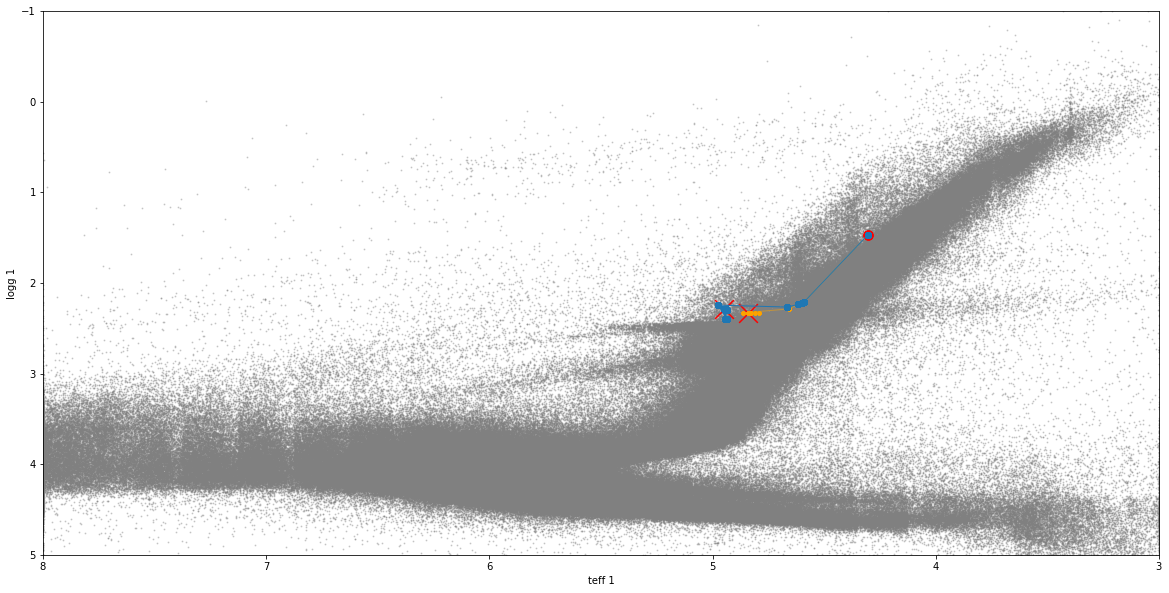

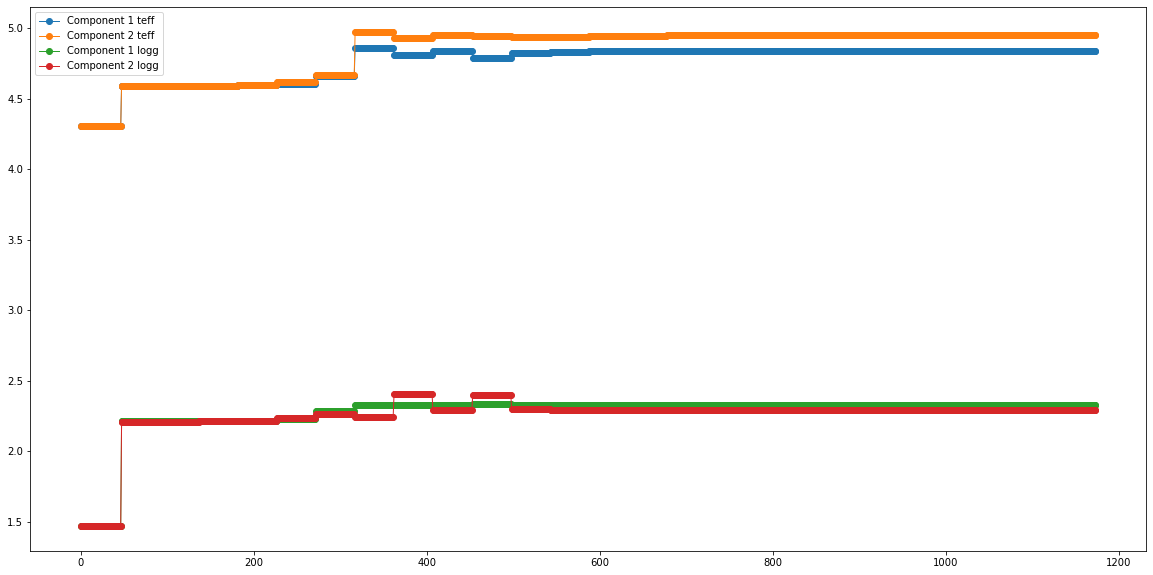

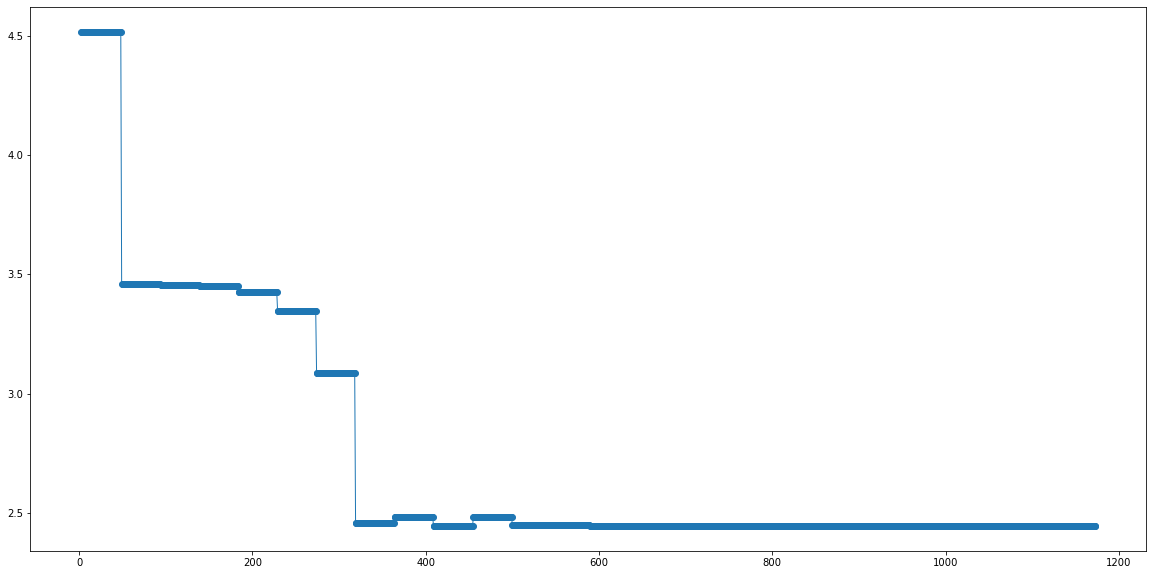

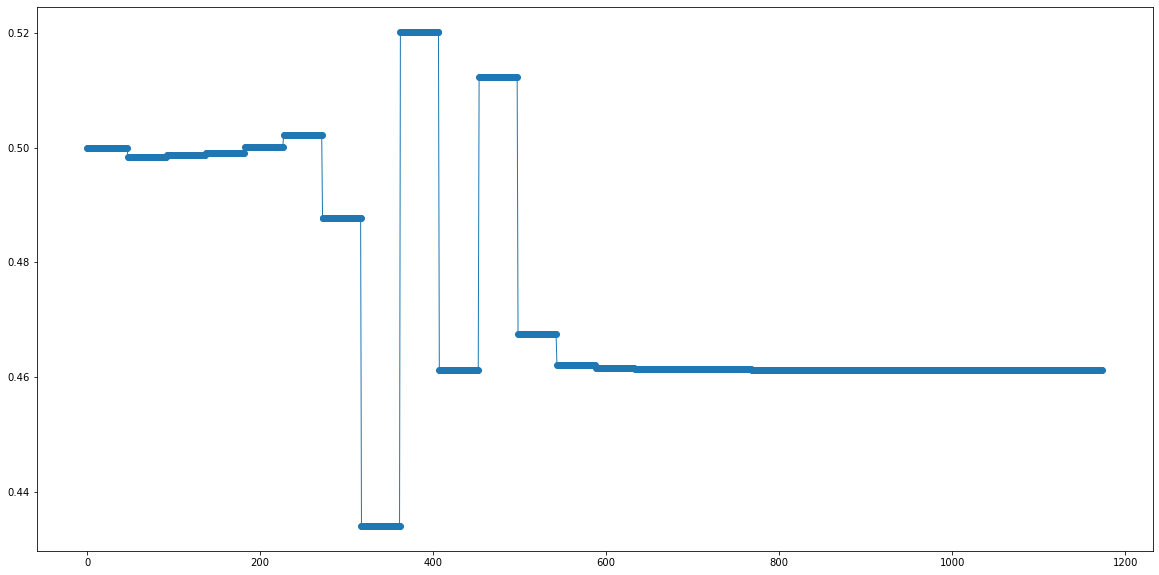

In [207]:
plt.figure(figsize=(20,10))
plt.scatter(GALAH_DR4['teff'].values / 1000, GALAH_DR4['logg'].values, c='gray', s=1, alpha=0.3)
plt.plot(model.param_data['teff_1'], model.param_data['logg_1'], '.', label='Component 1', ls='-', lw=1, c='orange', alpha=0.5)
plt.scatter(model.param_data['teff_1'][-1], model.param_data['logg_1'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_1'][0], model.param_data['logg_1'][0], label='Component 1', s=350,  c='red', marker='.')

plt.plot(model.param_data['teff_2'], model.param_data['logg_2'], 'o', label='Component 2', ls='-', lw=1)
plt.scatter(model.param_data['teff_2'][-1], model.param_data['logg_2'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_2'][0], model.param_data['logg_2'][0], label='Component 1', s=350,  c='red', marker='.')

plt.xlabel('teff 1')
plt.ylabel('logg 1' )
plt.ylim(-1, 5)
plt.xlim(3, 8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(20,10))
x = np.arange(0, len(model.param_data['teff_1']))
plt.plot(x, model.param_data['teff_1'], 'o', label='Component 1 teff', ls='-', lw=1)
plt.plot(x, model.param_data['teff_2'], 'o', label='Component 2 teff', ls='-', lw=1)

plt.plot(x, model.param_data['logg_1'], 'o', label='Component 1 logg', ls='-', lw=1)
plt.plot(x, model.param_data['logg_2'], 'o', label='Component 2 logg', ls='-', lw=1)
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['residual'], 'o', label='Component 1', ls='-', lw=1)

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['f_contr'], 'o', label='Component 1', ls='-', lw=1)



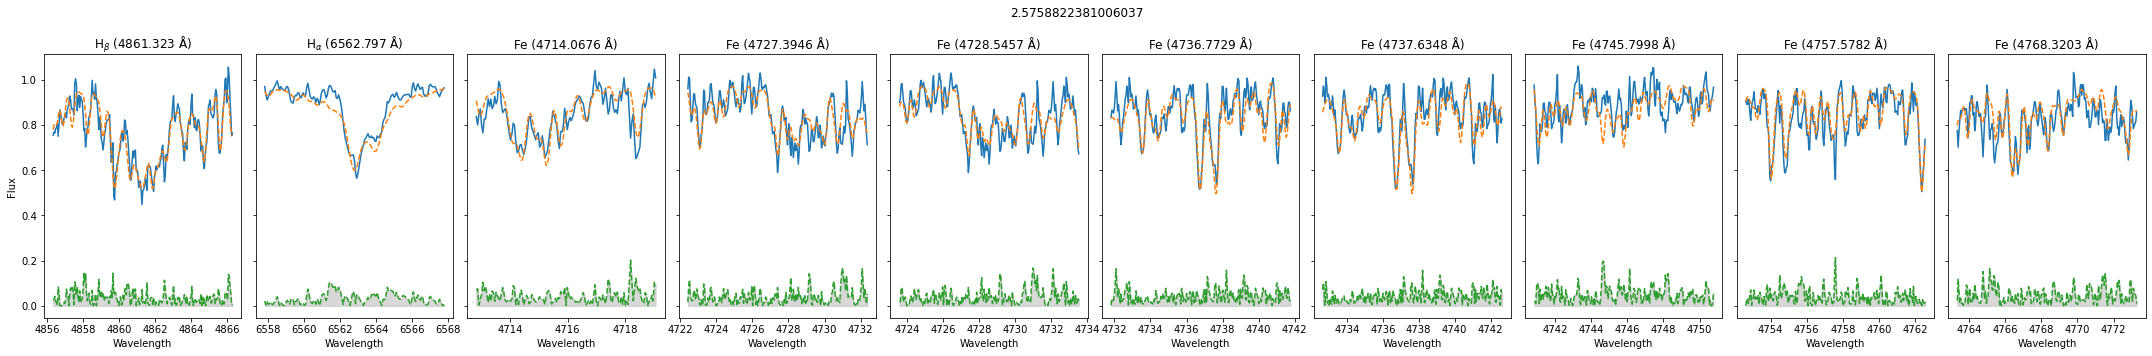

<Table length=15101>
       wave               sob         ...        smod         mob 
     float64            float64       ...      float64        bool
------------------ ------------------ ... ------------------ -----
 4712.807248783402 0.8377494798193145 ... 0.9081564299831242  True
 4712.853270574516 0.8005894656497954 ... 0.8761979950792974  True
 4712.899292365629 0.8473295663129368 ... 0.8515193698275472  True
 4712.945314156742 0.8717163316620767 ... 0.8422177229572496  True
 4712.991335947856 0.8001108438335998 ... 0.8500412280558998  True
 4713.037357738969 0.7655396790019225 ...  0.870041972747887  True
 4713.083379530082 0.8273962972643376 ... 0.8936049267051984  True
4713.1294013211955 0.8267750159678164 ... 0.9129577568931535  True
4713.1754231123095 0.8724902745062434 ... 0.9249173586648332  True
 4713.221444903422 0.9163271097782089 ... 0.9309986954473637  True
               ...                ... ...                ...   ...
 7884.591195401748 0.9846478259276189 ... 0.9881728401239489  True
 7884.664740499734  0.956912084959346 ... 0.9895947810262393  True
 7884.738285597719 0.9481407213957243 ... 0.9884991262145292  True
 7884.811830695705 0.9796450824239187 ... 0.9849432855811963  True
7884.8853757936895   0.97802263437115 ... 0.9794986909618244  True
 7884.958920891675  1.006258344965112 ... 0.9736694901856913  True
 7885.032465989661 1.0068053124664607 ... 0.9694990901250128  True
 7885.106011087647 1.0294041784317165 ...   0.96829939968855  True
7885.1795561856325 1.1048133131624416 ... 0.9703885236621161  True
 7885.253101283618  1.190953625769364 ... 0.9753735372724525 False

In [60]:

# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

save_spectrum

In [52]:

important_lines, important_molecules = af.load_dr3_lines()
len(important_lines)
important_lines[0:10][0][2]

'H$_\\beta$'

In [233]:
GALAH_DR4

sobject_id             tmass_id    gaiadr3_source_id  \
0        131216001101002  b'05190449-5849304'  4762794963745841536   
1        131216001101004  b'05194296-5852488'  4762782766038731776   
2        131216001101006  b'05242175-5855050'  4762746688313325568   
3        131216001101007  b'05235853-5855322'  4762746963191266560   
4        131216001101008  b'05250796-5856306'  4762744661088764928   
...                  ...                  ...                  ...   
1085515  230806004701393  b'01391378-6427588'  4711224157550934528   
1085516  230806004701394  b'01414949-6426307'  4711039508316839168   
1085517  230806004701395  b'01392892-6428458'  4711223500419993856   
1085518  230806004701396  b'01384113-6429329'  4711200586770414720   
1085519  230806004701399  b'01400092-6431073'  4711035350788501248   

            survey_name  field_id      setup           mjd         ra  \
0              b'other'        -1  b'single'  56642.574219  79.768745   
1              b'other'        -1  b'single'  56642.574219  79.929016   
2              b'other'        -1  b'single'  56642.574219  81.090652   
3              b'other'        -1  b'single'  56642.574219  80.993896   
4              b'other'        -1  b'single'  56642.574219  81.283173   
...                 ...       ...        ...           ...        ...   
1085515  b'galah_faint'      6962  b'single'  60162.769531  24.807459   
1085516  b'galah_faint'      6962  b'single'  60162.769531  25.456209   
1085517  b'galah_faint'      6962  b'single'  60162.769531  24.870417   
1085518  b'galah_faint'      6962  b'single'  60162.769531  24.671417   
1085519  b'galah_faint'      6962  b'single'  60162.769531  25.003876   

               dec  flag_sp  flag_sp_fit  opt_loop  flag_red  snr_px_ccd1  \
0       -58.825127        0            0         2         0    24.830610   
1       -58.880241        0            0        -1         0    26.910444   
2       -58.918076    10240            1         3         0     1.305176   
3       -58.925625        0            0        -1         0    15.785746   
4       -58.941841        0            0        -1         0    13.803916   
...            ...      ...          ...       ...       ...          ...   
1085515 -64.466393        0            0         1      2048    15.639088   
1085516 -64.441917    10240            1         2     34824     4.127307   
1085517 -64.479446        0            0         2      2568    16.419098   
1085518 -64.492500        0            0         2      2560    12.594277   
1085519 -64.518723        0            0         4      2056    12.542260   

         snr_px_ccd2  snr_px_ccd3  snr_px_ccd4   chi2_sp  px_used_perc  \
0          36.728691    52.325836    46.375481  0.778823            94   
1          39.116535    56.098625    49.236996  0.720102            94   
2           7.568689    19.137445    26.825100  0.870162            94   
3          32.320011    54.914253    55.229427  0.808800            94   
4          22.491350    35.755718    33.516693  0.793707            94   
...              ...          ...          ...       ...           ...   
1085515    20.052280    33.702351    24.873920  0.708738            94   
1085516     6.766768    15.086605    13.416698  1.206209            91   
1085517    27.174908    50.533207    40.533558  0.736091            94   
1085518    18.729958    33.518120    25.886162  0.661857            94   
1085519    17.056372    28.208437    19.343906  0.710195            94   

                 model_name       closest_model   comp_time  rv_comp_nr  \
0        b'5000_3.00_-0.50'  b'5000_3.00_-0.50'   66.573112           1   
1        b'5000_3.00_-0.75'  b'5000_3.00_-0.75'   70.718414           1   
2        b'3600_4.00_-0.25'  b'3800_4.00_-0.50'  248.433228           4   
3        b'4500_2.00_-0.75'  b'4500_2.00_-0.75'  125.496025           1   
4        b'5000_4.00_-0.75'  b'5000_4.00_-0.75'  168.238708           1   
...                     ...     